# Tracking Performance Study with CLD Z Samples

In this notebook we study **tracking performance** using CLD simulation samples
stored as Parquet files.

We will do two main things:

1. **Tracking Efficiency**

   - How often does a reconstructable generated particle (truth) have at least
     one associated reconstructed track?

2. **Tracking Resolution**

   - How well do reconstructed track parameters match their truth values?
   - We will look at:
     - Momentum resolution: Δp and Δp/p
     - Transverse momentum resolution: ΔpT and ΔpT/pT
     - Impact parameter resolution: σ(d₀) vs θ, in p-bins
   - All **separately for different particle types** (μ⁻, e⁻, π⁻), similar in spirit
     to the tracker performance plots in technical design studies.


This is done on **Z samples**, not on single-particle gun events


In [3]:
import sys
import glob
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep


hep.style.use("CMS")




sys.path.append("/eos/user/v/vriecher/mlpf")

from data_generation.preprocessing.utils_data_creation import particle_feature_order, track_feature_order, hit_feature_order

# Directory with your Parquet files (Z sample)
PARQUET_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"

# Collect all Parquet files
parquet_files = sorted(glob.glob(f"{PARQUET_DIR}/*.parquet"))

print(f"Found {len(parquet_files)} parquet files")
print("Example files:", parquet_files[:3])


Found 9835 parquet files
Example files: ['/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_10.parquet', '/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_100.parquet', '/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_1000.parquet']


In [4]:
print("particle_feature_order:")
for i, name in enumerate(particle_feature_order):
    print(f"{i:2d}: {name}")

print("\ntrack_feature_order:")
for i, name in enumerate(track_feature_order):
    print(f"{i:2d}: {name}")

# Define convenient indices based on the printed orders
GEN_PDG_IDX    = 0   # PDG
GEN_STATUS_IDX = 1   # generatorStatus
GEN_CHARGE_IDX = 2   # charge
GEN_PT_IDX     = 3   # pt
GEN_ETA_IDX    = 4   # eta
GEN_P_IDX      = 11  # p

TRK_PT_IDX  = 1   # pt
TRK_ETA_IDX = 2   # eta
TRK_P_IDX   = 5   # p
TRK_D0_IDX  = 18  # transverse impact parameter D0
HIT_ET_IDX        = hit_feature_order.index("et")
HIT_ETA_IDX       = hit_feature_order.index("eta")
HIT_E_IDX         = hit_feature_order.index("energy")       # = 5
HIT_SUBDET_IDX    = hit_feature_order.index("subdetector")  # = 10
HIT_TYPE_IDX      = hit_feature_order.index("type")         # = 11

print("\nUsing indices:")
print("GEN  pdg idx :", GEN_PDG_IDX,    "->", particle_feature_order[GEN_PDG_IDX])
print("GEN  status idx:", GEN_STATUS_IDX, "->", particle_feature_order[GEN_STATUS_IDX])
print("GEN  charge idx:", GEN_CHARGE_IDX, "->", particle_feature_order[GEN_CHARGE_IDX])
print("GEN  pt idx :", GEN_PT_IDX,  "->", particle_feature_order[GEN_PT_IDX])
print("GEN  eta idx:", GEN_ETA_IDX, "->", particle_feature_order[GEN_ETA_IDX])
print("GEN  p idx  :", GEN_P_IDX,   "->", particle_feature_order[GEN_P_IDX])
print("TRK  pt idx :", TRK_PT_IDX,  "->", track_feature_order[TRK_PT_IDX])
print("TRK  eta idx:", TRK_ETA_IDX, "->", track_feature_order[TRK_ETA_IDX])
print("TRK  p idx  :", TRK_P_IDX,   "->", track_feature_order[TRK_P_IDX])
print("TRK  D0 idx :", TRK_D0_IDX,  "->", track_feature_order[TRK_D0_IDX])


particle_feature_order:
 0: PDG
 1: generatorStatus
 2: charge
 3: pt
 4: eta
 5: phi
 6: sin_phi
 7: cos_phi
 8: energy
 9: simulatorStatus
10: mass
11: p
12: momentum.x
13: momentum.y
14: momentum.z
15: vertex.x
16: vertex.y
17: vertex.z
18: endpoint.x
19: endpoint.y
20: endpoint.z

track_feature_order:
 0: elemtype
 1: pt
 2: eta
 3: sin_phi
 4: cos_phi
 5: p
 6: px
 7: py
 8: pz
 9: referencePoint.x
10: referencePoint.y
11: referencePoint.z
12: referencePoint_calo.x
13: referencePoint_calo.y
14: referencePoint_calo.z
15: chi2
16: ndf
17: tanLambda
18: D0
19: omega
20: Z0
21: time
22: px_calo
23: py_calo
24: pz_calo

Using indices:
GEN  pdg idx : 0 -> PDG
GEN  status idx: 1 -> generatorStatus
GEN  charge idx: 2 -> charge
GEN  pt idx : 3 -> pt
GEN  eta idx: 4 -> eta
GEN  p idx  : 11 -> p
TRK  pt idx : 1 -> pt
TRK  eta idx: 2 -> eta
TRK  p idx  : 5 -> p
TRK  D0 idx : 18 -> D0


In [5]:
example_file = parquet_files[0]
print("Example file:", example_file)

data_ex = ak.from_parquet(example_file)
print("Fields in example file:", data_ex.fields)

print("X_gen events:", ak.num(data_ex["X_gen"], axis=0))
print("First few event sizes for X_gen:", ak.num(data_ex["X_gen"], axis=1)[:5])
print("First event ygen_track:", ak.to_list(data_ex["ygen_track"][0][:20]))
print("First event X_track:", ak.to_list(data_ex["X_track"][0][:20]))


Example file: /eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05/pf_tree_10.parquet
Fields in example file: ['X_track', 'X_hit', 'X_gen', 'ygen_track', 'ygen_hit', 'ygen_hit_calomother', 'X_pandora', 'pfo_calohit', 'pfo_track']
X_gen events: 100
First few event sizes for X_gen: [40, 22, 48, 15, 37]
First event ygen_track: [4, 3, 6, 9, -1, 0, 2, 4, 25, 2, -1, 11, 28, -1, -1, -1, 5, 10]
First event X_track: [[1.0, 5.595156669616699, 1.6228861808776855, -0.7734050750732422, -0.6339121460914612, 14.729310035705566, -3.54683780670166, -4.327322483062744, 13.625226974487305, 0.0, 0.0, 0.0, -567.0444946289062, -769.5150146484375, 2307.0, 19.65734100341797, 23.0, 2.4351823329925537, 0.2957787811756134, -0.00010716126416809857, -21.71738052368164, -1.0, -3.0855305194854736, -4.66740083694458, 13.625158309936523], [1.0, 2.5505285263061523, -1.7491825819015503, 0.708297848701477, 0.7059136629104614, 7.554429531097412, 1.8004529476165771, 1.8065338134765625, -7.110851764678955,

In [6]:
def compute_tracking_efficiency(
    parquet_dir,
    n_files=100,
    pt_min=0.0,
    eta_max=10,
    primary_r_max=9999,
    primary_z_max=9999,
    pdg_filter=None,
    pt_bins=None,
    eta_bins=None,
):
    """
    tracking efficiency = (# reconstructed gen particles) / (# reconstructable gen particles)
    """
    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    num_gen_reco_total = 0
    num_gen_matched_total = 0

    # binned efficency
    result = {}
    if pt_bins is not None:
        pt_bins = np.asarray(pt_bins)
        result["pt_bins"] = pt_bins
        result["pt_num"] = np.zeros(len(pt_bins) - 1, dtype=int)
        result["pt_den"] = np.zeros(len(pt_bins) - 1, dtype=int)
    if eta_bins is not None:
        eta_bins = np.asarray(eta_bins)
        result["eta_bins"] = eta_bins
        result["eta_num"] = np.zeros(len(eta_bins) - 1, dtype=int)
        result["eta_den"] = np.zeros(len(eta_bins) - 1, dtype=int)

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        ygen_track = data["ygen_track"]

        for gen_ev, ytrk_ev in zip(X_gen, ygen_track):
            gen = np.asarray(gen_ev)
            y   = np.asarray(ytrk_ev)

            n_gen = len(gen)
            if n_gen == 0:
                continue

            charge = gen[:, GEN_CHARGE_IDX]
            pt     = gen[:, GEN_PT_IDX]
            eta    = gen[:, GEN_ETA_IDX]

            # Primary particles
            status = gen[:, GEN_STATUS_IDX]
            vx = gen[:, 15]
            vy = gen[:, 16]
            vz = gen[:, 17]
            r  = np.sqrt(vx**2 + vy**2)

            is_primary = (status == 1) & (r < primary_r_max) & (np.abs(vz) < primary_z_max)

            # pdg filter
            if pdg_filter is not None:
                pdg = gen[:, GEN_PDG_IDX]
                is_pdg = np.isin(pdg, pdg_filter)
            else:
                is_pdg = np.ones(n_gen, dtype=bool)

            # Reconstructable
            reconstructable = (
                (np.abs(charge) > 0) &
                (np.abs(eta) < eta_max) &
                (pt > pt_min) &
                is_primary &
                is_pdg
            )

            if not np.any(reconstructable):
                continue

            gen_indices = np.arange(n_gen)
            reco_gen_indices = gen_indices[reconstructable]

            # valid Track to Gen indices
            y_valid = (y >= 0) & (y < n_gen)
            matched_gen_all = np.unique(y[y_valid])

            matched_gen = np.intersect1d(matched_gen_all, reco_gen_indices, assume_unique=True)

            num_gen_reco_total    += len(reco_gen_indices)
            num_gen_matched_total += len(matched_gen)

            # binned bookkeeping 
            if pt_bins is not None:
                pt_reco = pt[reconstructable]
                # Denominator: all reconstructable
                idx_pt_den = np.digitize(pt_reco, pt_bins) - 1
                for i in idx_pt_den:
                    if 0 <= i < len(result["pt_den"]):
                        result["pt_den"][i] += 1
                # Numerator: only matched
                mask_matched = np.isin(reco_gen_indices, matched_gen)
                pt_matched = pt_reco[mask_matched]
                idx_pt_num = np.digitize(pt_matched, pt_bins) - 1
                for i in idx_pt_num:
                    if 0 <= i < len(result["pt_num"]):
                        result["pt_num"][i] += 1

            if eta_bins is not None:
                eta_reco = eta[reconstructable]
                idx_eta_den = np.digitize(eta_reco, eta_bins) - 1
                for i in idx_eta_den:
                    if 0 <= i < len(result["eta_den"]):
                        result["eta_den"][i] += 1
                mask_matched = np.isin(reco_gen_indices, matched_gen)
                eta_matched = eta_reco[mask_matched]
                idx_eta_num = np.digitize(eta_matched, eta_bins) - 1
                for i in idx_eta_num:
                    if 0 <= i < len(result["eta_num"]):
                        result["eta_num"][i] += 1

    eff_global = num_gen_matched_total / num_gen_reco_total if num_gen_reco_total > 0 else np.nan

    # binned efficiencies from numerator/denominator
    if "pt_den" in result:
        with np.errstate(divide="ignore", invalid="ignore"):
            result["pt_eff"] = result["pt_num"] / result["pt_den"]
    if "eta_den" in result:
        with np.errstate(divide="ignore", invalid="ignore"):
            result["eta_eff"] = result["eta_num"] / result["eta_den"]

    return eff_global, result


In [7]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

pt_bins  = [0.5, 1, 2, 5, 10, 20, 50]
eta_bins = np.linspace(-2.5, 2.5, 11)

eff_cld, res_cld = compute_tracking_efficiency(CLD_DIR, n_files=100,
                                               pt_bins=pt_bins, eta_bins=eta_bins)
eff_arc, res_arc = compute_tracking_efficiency(ARC_DIR, n_files=100,
                                               pt_bins=pt_bins, eta_bins=eta_bins)

print("Globale Effizienz CLD:", eff_cld)
print("Globale Effizienz ARC:", eff_arc)


Globale Effizienz CLD: 0.9198112105423024
Globale Effizienz ARC: 0.8365346279227936


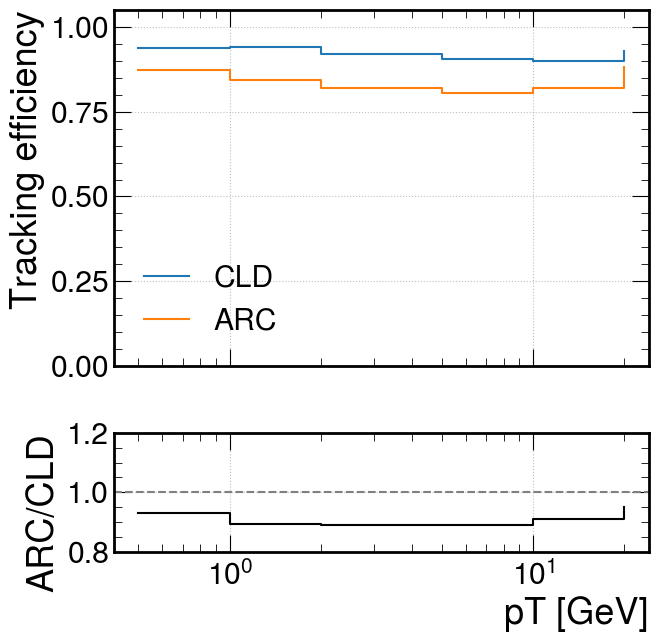

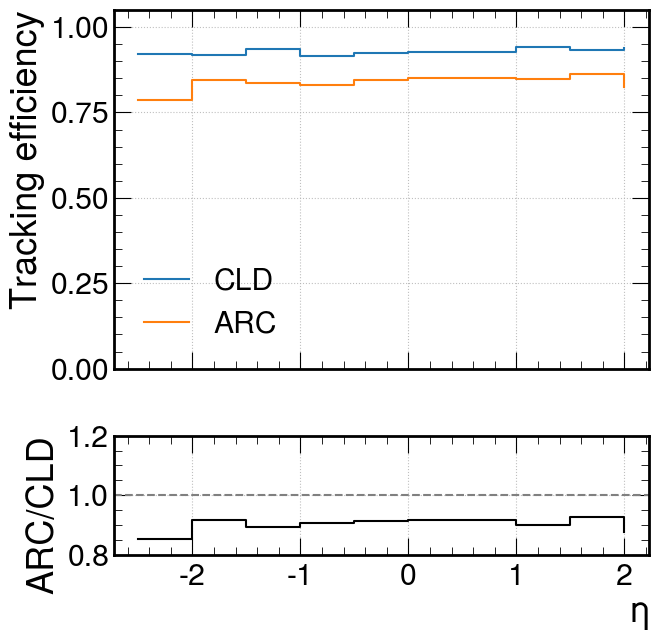

In [8]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top panel: Efficiencies
bin_edges = res_cld["pt_bins"]  # same for CLD + ARC
eff_cld   = res_cld["pt_eff"]
eff_arc   = res_arc["pt_eff"]

ax1.step(bin_edges[:-1], eff_cld, where="post", label="CLD")
ax1.step(bin_edges[:-1], eff_arc, where="post", label="ARC")

ax1.set_xscale("log")
ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Tracking efficiency")
ax1.legend()
ax1.grid(True)

# Bottom panel: Ratio
ratio = eff_arc / eff_cld

ax2.step(bin_edges[:-1], ratio, where="post", color="black")
ax2.axhline(1.0, color="gray", linestyle="--")
ax2.set_xscale("log")
ax2.set_ylim(0.8, 1.2)
ax2.set_xlabel("pT [GeV]")
ax2.set_ylabel("ARC/CLD")
ax2.grid(True)

plt.tight_layout()
plt.show()

#Eta bins
eta_edges = res_cld["eta_bins"]      
eta_eff_cld = res_cld["eta_eff"]
eta_eff_arc = res_arc["eta_eff"]

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(7, 7), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top panel: Efficiency vs eta
ax1.step(eta_edges[:-1], eta_eff_cld, where="post", label="CLD")
ax1.step(eta_edges[:-1], eta_eff_arc, where="post", label="ARC")

ax1.set_ylim(0, 1.05)
ax1.set_ylabel("Tracking efficiency")
ax1.legend()
ax1.grid(True)

#Bottom panel: Ratio 
eta_ratio = eta_eff_arc / eta_eff_cld

ax2.step(eta_edges[:-1], eta_ratio, where="post", color="black")
ax2.axhline(1.0, color="gray", linestyle="--")
ax2.set_ylim(0.8, 1.2)
ax2.set_xlabel(r"$\eta$")
ax2.set_ylabel("ARC/CLD")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [23]:
def compute_tracking_resolution(
    parquet_dir,
    n_files=100,
    pt_min=0.5,
    eta_max=2.5,
    primary_r_max=1.0,   # mm
    primary_z_max=10.0,  # mm
    pdg_filter=None,
    p_bins=None,
    theta_bins=None,
    clip_dpt_over_pt=None,  # None = no clipping; 
    clip_d0=None,          
):
    """
    Compute tracking resolutions for one detector geometry.

    For each matched track-gen pair that passes:
      - primary definition (status==1, r<primary_r_max, |z|<primary_z_max)
      - reconstructable (charged, |eta|<eta_max, pt>pt_min)
      - optional PDG filter (e.g. [-13] for mu-, [-11] for e-, [-211] for pi-)

    we compute:
      - dpt_over_pt = (pt_reco - pt_true) / pt_true
      - d0          = d0_reco

    and fill them into bins of (p_true, theta_true).

    Parameters:
    parquet_dir : str
        Directory with .parquet files.
    n_files : int
        Number of files to use.
    pt_min : float
        Minimum true pT [GeV] for reconstructable particles.
    eta_max : float
        Maximum eta for reconstructable particles.
    primary_r_max : float
        Maximum transverse distance from IP for primaries.
    primary_z_max : float
        Maximum z for primaries.
    pdg_filter : list[int] or None
        If not None, only particles with PDG in pdg_filter are used.
    p_bins : array-like
        Bin edges in true momentum p [GeV].
    theta_bins : array-like
        Bin edges in theta [deg].
    clip_dpt_over_pt : float or None
        If not None, pairs with |dpt_over_pt| > clip are discarded.
    clip_d0 : float or None
        If not None, pairs with |d0| > clip are discarded.

    Returns:
    result : dict
        {
          "p_bins"                 : array,
          "theta_bins"             : array,
          "sigma_dpt_over_pt"      : 2D array [n_p_bins, n_theta_bins],
          "sigma_d0"               : 2D array [n_p_bins, n_theta_bins],
          "count"                  : 2D array with counts,
          "global_sigma_dpt_over_pt": float (RMS over all pairs),
          "global_sigma_d0"         : float (RMS over all pairs),
        }
    """

    parquet_files = sorted(glob.glob(f"{parquet_dir}/*.parquet"))
    files = parquet_files[:n_files]

    if p_bins is None or theta_bins is None:
        raise ValueError("Please provide both p_bins and theta_bins.")

    p_bins = np.asarray(p_bins)
    theta_bins = np.asarray(theta_bins)

    n_p = len(p_bins) - 1
    n_t = len(theta_bins) - 1

    # accumulators
    sum_dpt_over_pt   = np.zeros((n_p, n_t), dtype=float)
    sumsq_dpt_over_pt = np.zeros((n_p, n_t), dtype=float)
    sum_d0            = np.zeros((n_p, n_t), dtype=float)
    sumsq_d0          = np.zeros((n_p, n_t), dtype=float)
    count             = np.zeros((n_p, n_t), dtype=int)

    # global lists (for global RMS)
    all_dpt_over_pt = []
    all_d0          = []

    for fn in files:
        data = ak.from_parquet(fn)

        X_gen      = data["X_gen"]
        X_track    = data["X_track"]
        ygen_track = data["ygen_track"]

        for gen_ev, trk_ev, y_ev in zip(X_gen, X_track, ygen_track):
            gen = np.asarray(gen_ev)
            trk = np.asarray(trk_ev)
            y   = np.asarray(y_ev)

            n_gen = len(gen)
            if n_gen == 0 or len(trk) == 0:
                continue

            # truth variables
            charge = gen[:, GEN_CHARGE_IDX]
            pt     = gen[:, GEN_PT_IDX]
            eta    = gen[:, GEN_ETA_IDX]
            status = gen[:, GEN_STATUS_IDX]

            # primary definition
            vx = gen[:, 15]
            vy = gen[:, 16]
            vz = gen[:, 17]
            r  = np.sqrt(vx**2 + vy**2)
            is_primary = (status == 1) & (r < primary_r_max) & (np.abs(vz) < primary_z_max)

            # PDG filter
            if pdg_filter is not None:
                pdg = gen[:, GEN_PDG_IDX]
                is_pdg = np.isin(pdg, pdg_filter)
            else:
                is_pdg = np.ones(n_gen, dtype=bool)

            # loop over tracks via truth-matching
            for i_trk, gen_idx in enumerate(y):
                if gen_idx < 0 or gen_idx >= n_gen:
                    continue

                if not is_primary[gen_idx] or not is_pdg[gen_idx]:
                    continue

                pt_true  = pt[gen_idx]
                eta_true = eta[gen_idx]
                q_true   = charge[gen_idx]

                # reconstructable
                if not (np.abs(q_true) > 0 and np.abs(eta_true) < eta_max and pt_true > pt_min):
                    continue

                p_true = gen[gen_idx, GEN_P_IDX]
                theta  = 2.0 * np.arctan(np.exp(-eta_true))
                theta_deg = np.degrees(theta)

                pt_reco = trk[i_trk, TRK_PT_IDX]
                d0_reco = trk[i_trk, TRK_D0_IDX]

                if pt_true <= 0:
                    continue

                dpt_over_pt = (pt_reco - pt_true) / pt_true
                d0_value    = d0_reco

                # clip unphysical outliers if desired
                if clip_dpt_over_pt is not None:
                    if not np.isfinite(dpt_over_pt) or np.abs(dpt_over_pt) > clip_dpt_over_pt:
                        continue
                if clip_d0 is not None:
                    if not np.isfinite(d0_value) or np.abs(d0_value) > clip_d0:
                        continue

                all_dpt_over_pt.append(dpt_over_pt)
                all_d0.append(d0_value)

                # binning
                ip = np.digitize(p_true, p_bins) - 1
                it = np.digitize(theta_deg, theta_bins) - 1

                if ip < 0 or ip >= n_p or it < 0 or it >= n_t:
                    continue

                sum_dpt_over_pt[ip, it]   += dpt_over_pt
                sumsq_dpt_over_pt[ip, it] += dpt_over_pt**2
                sum_d0[ip, it]            += d0_value
                sumsq_d0[ip, it]          += d0_value**2
                count[ip, it]             += 1

    # compute binned sigmas
    sigma_dpt_over_pt = np.full((n_p, n_t), np.nan)
    sigma_d0          = np.full((n_p, n_t), np.nan)

    nonzero = count > 0

    mean_dpt = np.zeros_like(sum_dpt_over_pt)
    mean_d0  = np.zeros_like(sum_d0)

    mean_dpt[nonzero] = sum_dpt_over_pt[nonzero] / count[nonzero]
    mean_d0[nonzero]  = sum_d0[nonzero] / count[nonzero]

    var_dpt = np.zeros_like(sum_dpt_over_pt)
    var_d0  = np.zeros_like(sum_d0)

    var_dpt[nonzero] = sumsq_dpt_over_pt[nonzero] / count[nonzero] - mean_dpt[nonzero]**2
    var_d0[nonzero]  = sumsq_d0[nonzero] / count[nonzero] - mean_d0[nonzero]**2

    sigma_dpt_over_pt[nonzero] = np.sqrt(np.clip(var_dpt[nonzero], 0, None))
    sigma_d0[nonzero]          = np.sqrt(np.clip(var_d0[nonzero], 0, None))

    # global RMS
    all_dpt_over_pt = np.asarray(all_dpt_over_pt)
    all_d0          = np.asarray(all_d0)

    global_sigma_dpt_over_pt = np.sqrt(np.mean(all_dpt_over_pt**2)) if len(all_dpt_over_pt) > 0 else np.nan
    global_sigma_d0          = np.sqrt(np.mean(all_d0**2))          if len(all_d0) > 0 else np.nan

    result = {
        "p_bins"                  : p_bins,
        "theta_bins"              : theta_bins,
        "sigma_dpt_over_pt"       : sigma_dpt_over_pt,
        "sigma_d0"                : sigma_d0,
        "count"                   : count,
        "global_sigma_dpt_over_pt": global_sigma_dpt_over_pt,
        "global_sigma_d0"         : global_sigma_d0,
    }

    return result


In [24]:
def plot_resolution_vs_theta(
    res_cld,
    res_arc,
    p_bin_index,
    quantity="dpt_over_pt",
    particle_label=r"\mu^{-}",
    min_entries=30,
    verbose=True,
):
    """
    Plot resolution vs theta for a given p-bin, comparing CLD and ARC:

      - upper panel: sigma (CLD & ARC)
      - lower panel: ratio ARC/CLD

    Also prints the number of entries per theta-bin for both geometries
    and warns if statistics are low.
    """

    theta_edges = res_cld["theta_bins"]
    p_edges     = res_cld["p_bins"]

    if p_bin_index < 0 or p_bin_index >= len(p_edges) - 1:
        raise ValueError(f"p_bin_index out of range (0 .. {len(p_edges)-2})")

    if quantity == "dpt_over_pt":
        key = "sigma_dpt_over_pt"
        y_label = r"$\sigma(\Delta p_T / p_T)$"
    elif quantity == "d0":
        key = "sigma_d0"
        y_label = r"$\sigma(d_0)$"
    else:
        raise ValueError("quantity must be 'dpt_over_pt' or 'd0'")

    sigma_cld = res_cld[key][p_bin_index, :]
    sigma_arc = res_arc[key][p_bin_index, :]
    count_cld = res_cld["count"][p_bin_index, :]
    count_arc = res_arc["count"][p_bin_index, :]

    # bin labels
    p_min = p_edges[p_bin_index]
    p_max = p_edges[p_bin_index + 1]
    p_label = rf"{p_min:.2g}–{p_max:.2g} GeV"

    # print stats
    if verbose:
        
        print(f" Resolution stats for p-bin {p_label}, particle {particle_label}")
        print(" theta-bin,count(CLD), count(ARC)")
        print("-----------------------------------------------------")

        for i in range(len(theta_edges) - 1):
            th_lo = theta_edges[i]
            th_hi = theta_edges[i+1]
            print(f" {th_lo:5.1f}–{th_hi:5.1f}°   {count_cld[i]:8d}      {count_arc[i]:8d}")

        low_cld = np.where(count_cld < min_entries)[0]
        low_arc = np.where(count_arc < min_entries)[0]

        if len(low_cld) > 0 or len(low_arc) > 0:
            print("\n WARNING: low statistics in some bins")
            if len(low_cld) > 0:
                print(f"   CLD: bins with <{min_entries} entries: {low_cld.tolist()}")
            if len(low_arc) > 0:
                print(f"   ARC: bins with <{min_entries} entries: {low_arc.tolist()}")
            print(" resolution may not be reliable in these bins.")
      
    # ratio only where both have enough entries and finite sigma
    ratio = np.full_like(sigma_cld, np.nan, dtype=float)
    good = (
        (count_cld >= min_entries)
        & (count_arc >= min_entries)
        & np.isfinite(sigma_cld)
        & np.isfinite(sigma_arc)
        & (sigma_cld > 0)
    )
    ratio[good] = sigma_arc[good] / sigma_cld[good]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(7, 7), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # top panel: sigma vs theta
    ax1.step(theta_edges[:-1], sigma_cld, where="post", label="CLD")
    ax1.step(theta_edges[:-1], sigma_arc, where="post", label="ARC")

    ax1.set_ylabel(y_label)
    ax1.set_title(rf"{y_label} vs $\theta$ for {particle_label}, p $\in$ [{p_label}]")
    ax1.grid(True, which="both", ls="--", alpha=0.5)
    ax1.legend()

    # bottom panel: ratio vs theta
    ax2.step(theta_edges[:-1], ratio, where="post", color="black")
    ax2.axhline(1.0, color="gray", linestyle="--")

    ax2.set_xlabel(r"$\theta$ [deg]")
    ax2.set_ylabel("ARC / CLD")
    ax2.grid(True, which="both", ls="--", alpha=0.5)
    ax2.set_ylim(0.2, 2)  
    plt.tight_layout()
    plt.show()


 Resolution stats for p-bin 1.5–4 GeV, particle \pi^{-}
 theta-bin,count(CLD), count(ARC)
-----------------------------------------------------
   0.0– 20.0°         19            17
  20.0– 40.0°         82            70
  40.0– 60.0°         85            78
  60.0– 80.0°         79            79
  80.0–100.0°         82            74
 100.0–120.0°         83            85
 120.0–140.0°         75            74
 140.0–160.0°         66            72

   CLD: bins with <30 entries: [0]
   ARC: bins with <30 entries: [0]
 resolution may not be reliable in these bins.


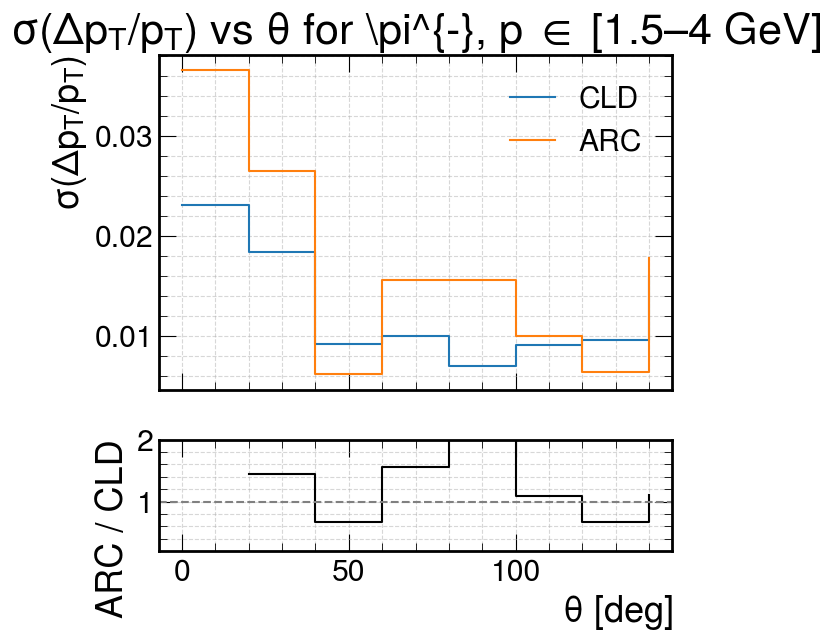

 Resolution stats for p-bin 1.5–4 GeV, particle \pi^{-}
 theta-bin,count(CLD), count(ARC)
-----------------------------------------------------
   0.0– 20.0°         19            17
  20.0– 40.0°         82            70
  40.0– 60.0°         85            78
  60.0– 80.0°         79            79
  80.0–100.0°         82            74
 100.0–120.0°         83            85
 120.0–140.0°         75            74
 140.0–160.0°         66            72

   CLD: bins with <30 entries: [0]
   ARC: bins with <30 entries: [0]
 resolution may not be reliable in these bins.


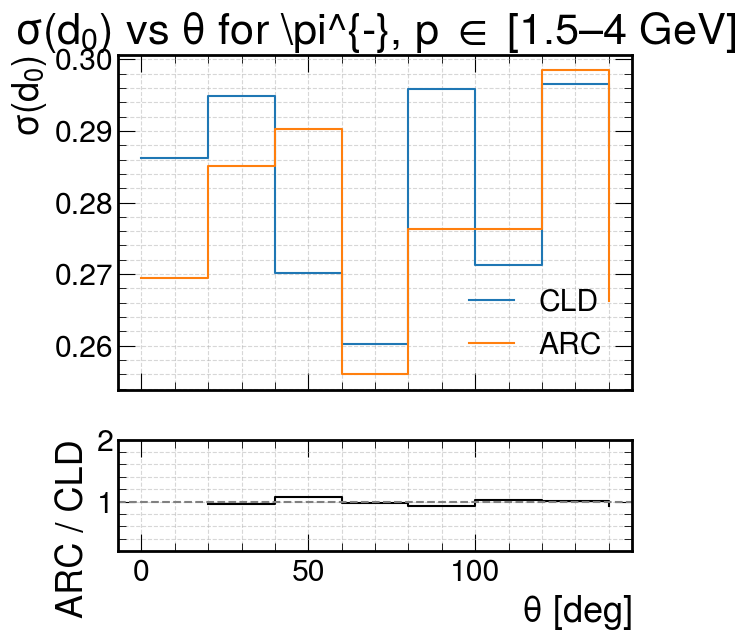

In [26]:
CLD_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/05"
ARC_DIR = "/eos/experiment/fcc/users/m/mgarciam/mlpf/CLD/train/Z_ss_CLD_o2_v05/arc"

p_bins     = np.array([0.5, 1.5, 4, 10, 25])
theta_bins = np.linspace(0, 160, 9)

# pions only (PDG = -211)
res_cld_pi = compute_tracking_resolution(
    CLD_DIR,
    n_files=100,
    pt_min=0.5,
    eta_max=2.5,
    primary_r_max=1.0,
    primary_z_max=10.0,
    pdg_filter=[-211],
    p_bins=p_bins,
    theta_bins=theta_bins,
    clip_dpt_over_pt=0.1,
    clip_d0=0.5,
)

res_arc_pi = compute_tracking_resolution(
    ARC_DIR,
    n_files=100,
    pt_min=0.5,
    eta_max=2.5,
    primary_r_max=1.0,
    primary_z_max=10.0,
    pdg_filter=[-211],
    p_bins=p_bins,
    theta_bins=theta_bins,
    clip_dpt_over_pt=0.1,
    clip_d0=0.5,
)



plot_resolution_vs_theta(
    res_cld_pi,
    res_arc_pi,
    p_bin_index=1,
    quantity="dpt_over_pt",
    particle_label=r"\pi^{-}",
    min_entries=30,
)



plot_resolution_vs_theta(
    res_cld_pi,
    res_arc_pi,
    p_bin_index=1,
    quantity="d0",
    particle_label=r"\pi^{-}",
    min_entries=30,
)


 Resolution stats for p-bin 4–10 GeV, particle \pi^{-}
 theta-bin,count(CLD), count(ARC)
-----------------------------------------------------
  20.0– 40.0°         54            52
  40.0– 60.0°         62            67
  60.0– 80.0°         59            62
  80.0–100.0°         79            78
 100.0–120.0°         52            55
 120.0–140.0°         77            71
 140.0–160.0°         53            51


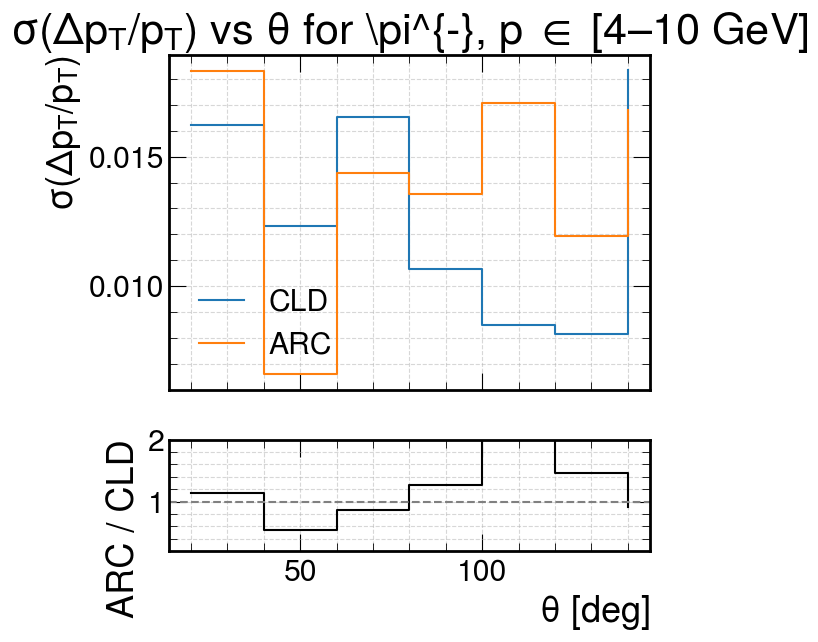

 Resolution stats for p-bin 4–10 GeV, particle \pi^{-}
 theta-bin,count(CLD), count(ARC)
-----------------------------------------------------
  20.0– 40.0°         54            52
  40.0– 60.0°         62            67
  60.0– 80.0°         59            62
  80.0–100.0°         79            78
 100.0–120.0°         52            55
 120.0–140.0°         77            71
 140.0–160.0°         53            51


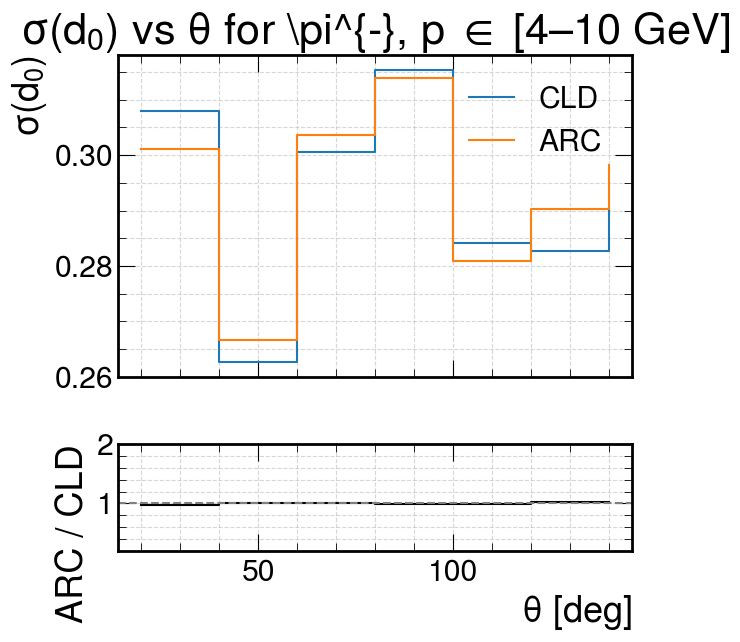

In [21]:
plot_resolution_vs_theta(
    res_cld_pi,
    res_arc_pi,
    p_bin_index=2,
    quantity="dpt_over_pt",
    particle_label=r"\pi^{-}",
    min_entries=30
)



plot_resolution_vs_theta(
    res_cld_pi,
    res_arc_pi,
    p_bin_index=2,
    quantity="d0",
    particle_label=r"\pi^{-}",
    min_entries=30,
)

